In [1]:
import os
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split

In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import torch.nn.functional as F

torch.manual_seed(42)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [4]:
PATH = r"/kaggle/input/architectural-heritage-elements-image64-dataset"
classes = ["altar", "apse", "bell_tower", "column", "dome(inner)", "dome(outer)", "flying_buttress", "gargoyle", "stained_glass", "vault"]
class_to_label = {name:idx for idx, name in enumerate(classes)}
label_to_class = {value:key for key, value in class_to_label.items()}

In [5]:
def convert_to_dataframe(root_folder, mapping=class_to_label):
    paths = []
    labels = []
    for label in os.listdir(root_folder):
        label_folder = os.path.join(root_folder, label)
        if os.path.isdir(label_folder):
            for file_name in os.listdir(label_folder):
                file_path = os.path.join(label_folder, file_name)
                paths.append(file_path)
                labels.append(mapping[label])
    df = pd.DataFrame({"path": paths, "label": labels})
    return df

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root=PATH, transform=None):
        super().__init__()
        self.dataframe = dataframe
        self.root = root
        self.transform = transform
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        #label
        label = self.dataframe["label"].iloc[index]
        label = torch.tensor(label)
        
        #image
        image_path = os.path.join(self.root, self.dataframe["path"].iloc[index])
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

In [7]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    error = 0
    correct_predictions = 0
    total_predictions = 0

    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)        
        pred = model(X)
        loss = criterion(pred, y.squeeze())
        error += loss.item()

        _, pred_indices = torch.max(pred, 1)
        correct_predictions += (pred_indices == y).sum().item()
        total_predictions += y.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return error / len(dataloader), correct_predictions / total_predictions

In [8]:
def evaluate(model, dataloader, criterion):
    model.eval()
    error = 0
    correct_predictions = 0
    total_predictions = 0

    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            pred = model(X)
            loss = criterion(pred, y)
            error += loss.item()
            _, pred_indices = torch.max(pred, 1)
            correct_predictions += (pred_indices == y).sum().item()
            total_predictions += y.size(0)
            
    return error / len(dataloader), correct_predictions / total_predictions

In [9]:
EPOCHS = 15
def run_over_epoches(model, train_dataloader, dev_dataloader, criterion, optimizer):
    history = {
        "train_losses" : [],
        "dev_losses" : [],
        "train_accuracies" : [],
        "dev_accuracies" : []
    }
    
    best = {
        "model" : model,
        "accuracy" :  0
    }
    
    for i, _ in enumerate(tqdm(range(EPOCHS))):
        train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer)
        dev_loss, dev_accuracy = evaluate(model, dev_dataloader, criterion)
        history["train_losses"].append(train_loss)
        history["dev_losses"].append(dev_loss)
        history["train_accuracies"].append(train_accuracy)
        history["dev_accuracies"].append(dev_accuracy) 
        if dev_accuracy > best["accuracy"]:
            best["model"] = model
            best["accuracy"] = dev_accuracy
        print(f"{i+1}th epoch ----> train_accuracy : {train_accuracy} |||| dev_accuracy : {dev_accuracy}")
    return history, best

In [10]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
    x_axis = range(1, EPOCHS+1)
    ax1.plot(x_axis, history["train_losses"], label="train")
    ax1.plot(x_axis, history["dev_losses"], label="dev")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax2.plot(x_axis, history["train_accuracies"], label="train")
    ax2.plot(x_axis, history["dev_accuracies"], label="dev")
    ax2.set_xlabel("EPOCH")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    plt.show();

In [11]:
def find_mean_std(dataset):
    channel_means, channel_stds = 0, 0
    for img, _ in dataset:
        channel_means += torch.mean(img, dim=(1, 2))
        channel_stds += torch.std(img, dim=(1, 2))
    channel_means /= len(dataset)
    channel_stds /= len(dataset)
    return channel_means, channel_stds

# find_mean_std(train_dataset) # ---> tensor([0.4210, 0.4001, 0.3761]), tensor([0.2109, 0.2083, 0.2143])
# find_mean_std(dev_dataset) # ---> tensor([0.4415, 0.4238, 0.4051]), tensor([0.2009, 0.2015, 0.2174])
# find_mean_std(test_dataset) # ---> tensor([0.4539, 0.4426, 0.4285]), tensor([0.1931, 0.1915, 0.2124])

In [12]:
train_df = convert_to_dataframe(PATH+r"/train")
test_df = convert_to_dataframe(PATH+r"/test")
train_df, dev_df = train_test_split(train_df, train_size=0.8, random_state=42, stratify=train_df["label"])
test_df, _ = train_test_split(test_df, train_size=None, random_state=42)

In [13]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomResizedCrop((224, 224), antialias=True),
    transforms.RandomRotation(15),
    transforms.Normalize([0.4210, 0.4001, 0.3761], [0.2109, 0.2083, 0.2143])
])
dev_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize([0.4415, 0.4238, 0.4051], [0.2009, 0.2015, 0.2174])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize([0.4539, 0.4426, 0.4285], [0.1931, 0.1915, 0.2124])
])
train_dataset = CustomDataset(train_df, transform=train_transform)
dev_dataset = CustomDataset(dev_df, transform=dev_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
from collections import Counter
def find_class_weights(train_dataset):
    labels = [label for _, label in train_dataset]
    class_counts = Counter(labels)
    class_weights = [len(train_dataset) / (class_counts[i] * 1.0) for i in range(len(class_counts))]
    class_weights = torch.tensor(class_weights, device=DEVICE)
    
# class_weights = find_class_weights(train_dataset)
class_weights = torch.tensor([11.9352, 19.9115, 10.0173, 5.2726, 17.5792, 8.5847, 25.2461, 6.4165,
        10.0671, 9.2301], dtype=torch.float, device=DEVICE)

In [16]:
from torchvision import models

model = models.densenet161(weights=models.densenet.DenseNet161_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False
    
parameters = list(model.parameters())
for i in range(-3, 0, 1):
    parameters[i].requires_grad = True

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)
)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 90.8MB/s]


In [17]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)
history, best = run_over_epoches(model, train_dataloader, dev_dataloader, criterion, optimizer)

  7%|▋         | 1/15 [01:57<27:24, 117.49s/it]

1th epoch ----> train_accuracy : 0.6274679170779862 |||| dev_accuracy : 0.7685093780848964


 13%|█▎        | 2/15 [03:15<20:25, 94.30s/it] 

2th epoch ----> train_accuracy : 0.6973099703849951 |||| dev_accuracy : 0.851431391905232


 20%|██        | 3/15 [04:33<17:19, 86.66s/it]

3th epoch ----> train_accuracy : 0.7202615992102666 |||| dev_accuracy : 0.8460019743336624


 27%|██▋       | 4/15 [05:51<15:15, 83.25s/it]

4th epoch ----> train_accuracy : 0.7334649555774926 |||| dev_accuracy : 0.8677196446199408


 33%|███▎      | 5/15 [07:08<13:32, 81.26s/it]

5th epoch ----> train_accuracy : 0.7414856860809477 |||| dev_accuracy : 0.8672260612043435


 40%|████      | 6/15 [08:26<12:01, 80.16s/it]

6th epoch ----> train_accuracy : 0.7346989141164857 |||| dev_accuracy : 0.8800592300098716


 47%|████▋     | 7/15 [09:44<10:35, 79.38s/it]

7th epoch ----> train_accuracy : 0.7492596248766041 |||| dev_accuracy : 0.8603158933859822


 53%|█████▎    | 8/15 [11:02<09:11, 78.75s/it]

8th epoch ----> train_accuracy : 0.7544422507403751 |||| dev_accuracy : 0.8756169792694966


 60%|██████    | 9/15 [12:19<07:49, 78.31s/it]

9th epoch ----> train_accuracy : 0.7528381046396841 |||| dev_accuracy : 0.8820335636722606


 67%|██████▋   | 10/15 [13:36<06:29, 77.99s/it]

10th epoch ----> train_accuracy : 0.7640671273445212 |||| dev_accuracy : 0.8988153998025666


 73%|███████▎  | 11/15 [14:53<05:10, 77.71s/it]

11th epoch ----> train_accuracy : 0.7622161895360315 |||| dev_accuracy : 0.8948667324777887


 80%|████████  | 12/15 [16:11<03:53, 77.72s/it]

12th epoch ----> train_accuracy : 0.7599950641658441 |||| dev_accuracy : 0.8983218163869694


 87%|████████▋ | 13/15 [17:30<02:35, 77.99s/it]

13th epoch ----> train_accuracy : 0.7675222112537019 |||| dev_accuracy : 0.8864758144126358


 93%|█████████▎| 14/15 [18:48<01:18, 78.07s/it]

14th epoch ----> train_accuracy : 0.7672754195459033 |||| dev_accuracy : 0.8736426456071076


100%|██████████| 15/15 [20:06<00:00, 80.45s/it]

15th epoch ----> train_accuracy : 0.7711006910167818 |||| dev_accuracy : 0.8963474827245804


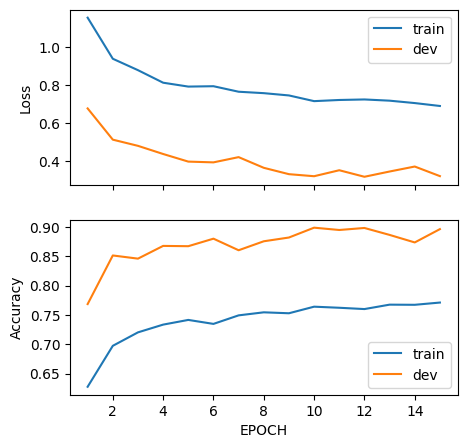

In [18]:
plot_history(history)

In [19]:
best["accuracy"]

0.8988153998025666

In [20]:
# summary(model, (3, 224, 224))

In [21]:
torch.save(best["model"], 'model.pth')

# final result (of totally unseen data)

In [22]:
number_per_labels = {}
correct_per_labels = {}

for X, y in test_dataloader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        pred = best["model"](X)
        pred_index = pred.argmax()
        for label in y:
            number_per_labels[label.item()] = number_per_labels.get(label.item(), 0) + 1
        if pred_index == y:
            correct_per_labels[y.item()] = correct_per_labels.get(y.item(), 0) + 1

In [23]:
percentages = {}
for label, correct_count in correct_per_labels.items():
    total_count = number_per_labels[label]
    percentages[label] = correct_count / total_count

percentages

{0: 0.9278350515463918,
 3: 0.8616352201257862,
 4: 0.7735849056603774,
 6: 0.9056603773584906,
 2: 0.8615384615384616,
 9: 0.9411764705882353,
 7: 0.8944444444444445,
 5: 0.9649122807017544,
 8: 0.9532710280373832,
 1: 0.6585365853658537}

In [24]:
total_correct = sum(correct_per_labels.values())
total_samples = sum(number_per_labels.values())
accuracy = total_correct / total_samples
accuracy

0.8926875593542261